In [ ]:
# Precision-Recall Curve, per-class
# Precision, Recall, F1, AP, IoU

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import utils

# Load ground truth data
cocoGt=COCO("cocoGt.json")

# Load prediction data
cocoDt=cocoGt.loadRes("cocoDt.json")

# Initialize COCOeval object
cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
cocoEval.params.useCats = 1

# Evaluate on a subset of images (optional)
# cocoEval.params.imgIds = [5]  # Remove this line to evaluate on all images

# Run evaluation
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [4]:
recall = cocoEval.eval['recall'][:, :, 0, 2].mean()
precision = cocoEval.eval['precision'][:, :, :, 0, 2].mean()
f1 = 2 * precision * recall / (precision + recall)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1: {f1:.3f}")

Precision: 0.188
Recall: 0.254
F1: 0.216


In [ ]:
# how to be with confidence threshold?
# cocoDt.anns = {k: v for k, v in cocoDt.anns.items() if v['score'] > 0.45}

In [33]:
cocoEval.eval["precision"].shape
# (iou_thres, recall, classes, area, max_dets)

(10, 101, 10, 4, 3)

In [129]:
# cocoEval.ious
# cocoEval.evalImgs[1]
# cocoEval._gts[(1,1)]

In [3]:
aRng = cocoEval.params.areaRng[0]
eval_imgs = [ev for ev in cocoEval.evalImgs if ev is not None and ev['aRng'] == aRng]

N = len(eval_imgs)
T = len(cocoEval.params.iouThrs)
K = len(cocoEval.params.catIds)

true_positives = np.zeros((K, N, T))
false_positives = np.zeros((K, N, T))
false_negatives = np.zeros((K, N, T))
scores = []


for i, eval_img in enumerate(eval_imgs):

    catId = eval_img['category_id']
    imgId = eval_img['image_id']
    
    true_positives[catId-1, i] = np.sum(eval_img['dtMatches'] > 0, axis=1)
    false_positives[catId-1, i] = np.sum(eval_img['dtMatches'] == 0, axis=1)
    false_negatives[catId-1, i] = np.sum(eval_img['gtMatches'] == 0, axis=1)
    scores.append(eval_img['dtScores'])

In [4]:
tp = true_positives.sum(1)
fp = false_positives.sum(1)
fn = false_negatives.sum(1)

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Precision: {precision.mean():.3f}")
print(f"Recall: {recall.mean():.3f}")

Precision: 0.350
Recall: 0.254


In [5]:
tp = true_positives.sum((0,1))
fp = false_positives.sum((0,1))
fn = false_negatives.sum((0,1))

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Precision: {precision.mean():.3f}")
print(f"Recall: {recall.mean():.3f}")

Precision: 0.301
Recall: 0.215


P/R vs IoU


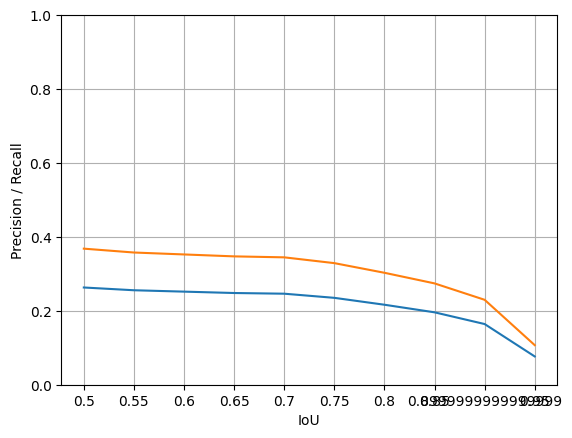

In [43]:
print("P/R vs IoU")
tp = true_positives.sum((0,1))
fp = false_positives.sum((0,1))
fn = false_negatives.sum((0,1))

precision = tp / (tp + fp)
recall = tp / (tp + fn)

plt.plot(recall)
plt.plot(precision)
plt.title("Precision / Recall vs IoU")
plt.xlabel("IoU")
plt.ylabel("Precision / Recall")
plt.xticks(range(0, len(cocoEval.params.iouThrs), 1), cocoEval.params.iouThrs[::1])
plt.ylim(0, 1)
plt.grid()

Per-class


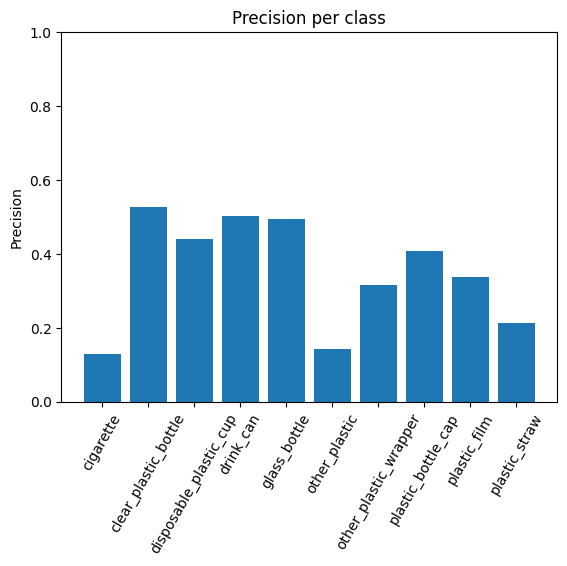

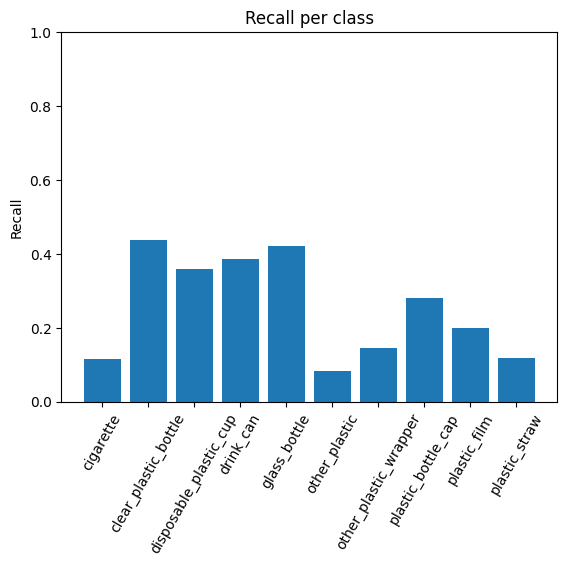

In [4]:
print("Per-class")

tp = true_positives.sum(1)
fp = false_positives.sum(1)
fn = false_negatives.sum(1)

precision = tp / (tp + fp)
recall = tp / (tp + fn)

# print(f"Precision: {precision.mean(-1)}")
# print(f"Recall: {recall.mean(-1)}")


plt.bar(range(K), precision.mean(-1))
plt.xticks(range(K), [cocoGt.cats[k]['name'] for k in range(1, K+1)], rotation=60)
plt.ylabel("Precision")
plt.title("Precision per class")
plt.ylim(0, 1)
plt.show()

plt.bar(range(K), recall.mean(-1))
plt.xticks(range(K), [cocoGt.cats[k]['name'] for k in range(1, K+1)], rotation=60)
plt.ylabel("Recall")
plt.title("Recall per class")
plt.ylim(0, 1)
plt.show()

Text(0.5, 1.0, 'Precision / Recall vs Score')

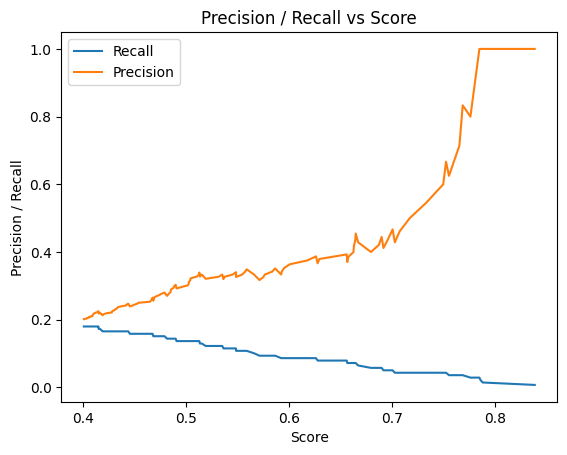

In [348]:
cat_id = 1
t = 0
tps, fps, scores, n_positives = utils.get_counts_and_scores(cocoEval, cat_id, t)

# Cumulative sums
tps = np.cumsum(tps)
fps = np.cumsum(fps)
# fns = np.cumsum(fns)

# Precision and recall
precision = tps / (tps + fps)
recall = tps / n_positives

# Precision / Recall vs Score
plt.plot(scores, recall, label="Recall")
plt.plot(scores, precision, label="Precision")
plt.xlabel("Score")
plt.ylabel("Precision / Recall")
plt.legend()
plt.title("Precision / Recall vs Score")

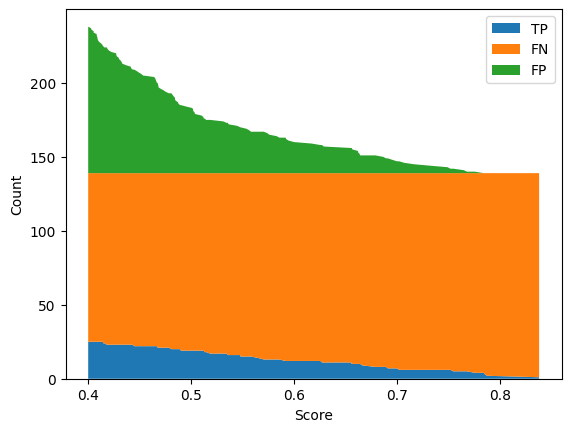

In [97]:
fns = n_positives - tps

# Plot stacked line plot
# with tp, fn, fp
plt.stackplot(scores, tps, fns, fps, labels=["TP", "FN", "FP"])
plt.xlabel("Score")
plt.ylabel("Count")
plt.legend()

In [84]:
recall[-1], precision[-1]

(0.17985611510791366, 0.20161290322580644)

In [75]:
len(recall)

124

In [64]:

p = cocoEval.params
p.catIds = p.catIds if p.useCats == 1 else [-1]
T           = len(p.iouThrs)
R           = len(p.recThrs)
K           = len(p.catIds) if p.useCats else 1
A           = len(p.areaRng)
M           = len(p.maxDets)
precision   = -np.ones((T,R,K,A,M)) # -1 for the precision of absent categories
recall      = -np.ones((T,K,A,M))
scores      = -np.ones((T,R,K,A,M))

# create dictionary for future indexing
_pe = cocoEval._paramsEval
catIds = _pe.catIds if _pe.useCats else [-1]
setK = set(catIds)
setA = set(map(tuple, _pe.areaRng))
setM = set(_pe.maxDets)
setI = set(_pe.imgIds)
# get inds to evaluate
k_list = [n for n, k in enumerate(p.catIds)  if k in setK]
m_list = [m for n, m in enumerate(p.maxDets) if m in setM]
a_list = [n for n, a in enumerate(map(lambda x: tuple(x), p.areaRng)) if a in setA]
i_list = [n for n, i in enumerate(p.imgIds)  if i in setI]
I0 = len(_pe.imgIds)
A0 = len(_pe.areaRng)
# retrieve E at each category, area range, and max number of detections
for k, k0 in enumerate(k_list):
    Nk = k0*A0*I0
    for a, a0 in enumerate(a_list):
        Na = a0*I0
        for m, maxDet in enumerate(m_list):
            if maxDet != 100:
                continue
            E = [cocoEval.evalImgs[Nk + Na + i] for i in i_list]
            E = [e for e in E if not e is None]
            if len(E) == 0:
                continue
            dtScores = np.concatenate([e['dtScores'][0:maxDet] for e in E])

            # different sorting method generates slightly different results.
            # mergesort is used to be consistent as Matlab implementation.
            inds = np.argsort(-dtScores, kind='mergesort')
            dtScoresSorted = dtScores[inds]

            dtm  = np.concatenate([e['dtMatches'][:,0:maxDet] for e in E], axis=1)[:,inds]
            dtIg = np.concatenate([e['dtIgnore'][:,0:maxDet]  for e in E], axis=1)[:,inds]
            gtm = np.concatenate([e['gtMatches'] for e in E], axis=1)[:,inds]
            gtIg = np.concatenate([e['gtIgnore'] for e in E])
            npig = np.count_nonzero(gtIg==0 )
            if npig == 0:
                continue
            tps = np.logical_and(               dtm,  np.logical_not(dtIg) )
            fps = np.logical_and(np.logical_not(dtm), np.logical_not(dtIg) )
            fns = np.logical_and(               gtm,  np.logical_not(dtIg) )

            tp_sum = np.cumsum(tps, axis=1).astype(dtype=float)
            fp_sum = np.cumsum(fps, axis=1).astype(dtype=float)
            fn_sum = np.cumsum(fns, axis=1).astype(dtype=float)
            raise

RuntimeError: No active exception to reraise

In [70]:
len(E), npig

(76, 139)

In [69]:
rc[0][-1], pr[0][-1]

(0.17985611510791366, 0.20161290322580644)

In [67]:
pr = tp_sum / (fp_sum + tp_sum + np.spacing(1))
pr.shape

(10, 124)

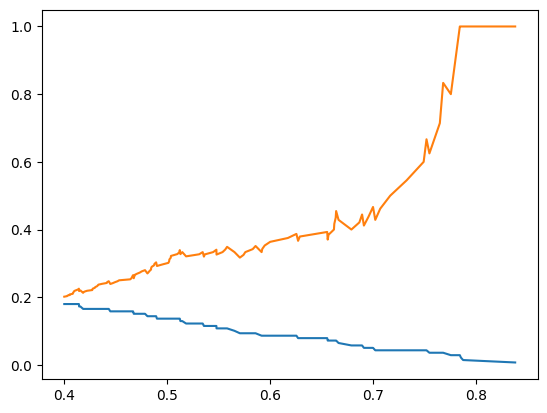

In [68]:
rc = tp_sum / npig
rc2 = tp_sum / (fn_sum + tp_sum + np.spacing(1))
pr = tp_sum / (fp_sum + tp_sum + np.spacing(1))
f1 = 2 * pr * rc / (pr + rc + np.spacing(1))
f1_2 = 2 * pr * rc2 / (pr + rc2 + np.spacing(1))

plt.plot(dtScoresSorted, rc[0])
plt.plot(dtScoresSorted, pr[0])
# plt.plot(dtScoresSorted, rc2[0])
# plt.plot(dtScoresSorted, f1_2[0])
# plt.plot(rc[0], pr[0])

## Per-class TP, FN, FP Counts

In [186]:
aRng = cocoEval.params.areaRng[0]
eval_imgs = [ev for ev in cocoEval.evalImgs if ev is not None and ev['aRng'] == aRng]

N = len(eval_imgs)
T = len(cocoEval.params.iouThrs)
K = len(cocoEval.params.catIds)

true_positives = np.zeros((K, N, T))
false_positives = np.zeros((K, N, T))
false_negatives = np.zeros((K, N, T))
scores = []
# n_positives = np.zeros(K)


for i, eval_img in enumerate(eval_imgs):

    catId = eval_img['category_id']
    imgId = eval_img['image_id']
    
    true_positives[catId-1, i] = np.sum(eval_img['dtMatches'] > 0, axis=1)
    false_positives[catId-1, i] = np.sum(eval_img['dtMatches'] == 0, axis=1)
    false_negatives[catId-1, i] = np.sum(eval_img['gtMatches'] == 0, axis=1)
    scores.append(eval_img['dtScores'])
    # n_positives[catId-1] += eval_img['gtMatches'].shape[1]

In [192]:
iou_thres = 0

tp = true_positives.sum(1)[:,t]
fp = false_positives.sum(1)[:,t]
fn = false_negatives.sum(1)[:,t]

# normalize
# tp / (tp + fn)
# fn / (tp + fn)
# fp / (tp + fn)
support = tp + fn

tp_rel = tp / support
fp_rel = fp / support
fn_rel = fn / support

In [193]:
# Load category names from COCO
cat_ids = cocoEval.params.catIds
cat_names = [cat['name'] for cat in cocoEval.cocoGt.loadCats(cat_ids)]

sort_indices = np.argsort(tp_rel)
cat_names = [cat_names[i] for i in sort_indices]

# create DF
data = {
    "count": np.concatenate([tp[sort_indices], fn[sort_indices], fp[sort_indices]]),
    "type": ["TP"]*K + ["FN"]*K + ["FP"]*K,
    "category": cat_names*3
}

df = pd.DataFrame(data)

In [194]:
import plotly.express as px
color_map = {
    'TP': '#1fb466',  # Light blue color for Product A
    'FN': '#dd3f3f',    # Magenta color for Product B
    'FP': '#d5a5a5'   # Lime green color for Product C
}
fig = px.bar(df, x="category", y="count", color="type", title="Per-class Counts",
             labels={'count': 'Total Count'}, text='count',
             color_discrete_map=color_map)

# change colors

fig.show()

## Per-class AP Radar Chart

In [105]:
import plotly.graph_objects as go

pr = cocoEval.eval['precision'][:, :, :, 0, 2]
pr_per_class = pr.mean(axis=(0, 1))

# Load category names from COCO
cat_ids = cocoEval.params.catIds
cat_names = [cat['name'] for cat in cocoEval.cocoGt.loadCats(cat_ids)]

# Create a radar chart
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=pr_per_class,
    theta=cat_names,
    fill='toself',
    name='AP per Class'
))

# Update the layout for better visualization
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]  # Assuming AP values are normalized between 0 and 1
        )
    ),
    title="Per-class Average Precision (AP)"
)

# Show the plot
fig.show()

## Per-image plots

In [199]:
true_positives, false_positives, false_negatives, scores = utils.get_counts(cocoEval)

In [268]:
print("Distplots")

tp = true_positives.sum(0)
fp = false_positives.sum(0)
fn = false_negatives.sum(0)

# m = p > 0
pos = tp + fn
pred = tp + fp

precision = tp / (tp + fp)
recall = tp / (tp + fn)

# precision[m & np.isnan(precision)] = 0.
# recall[m & np.isnan(recall)] = 0.
# precision[(pred==0) & (pos!=0)] = 0.

precision = np.nanmean(precision, -1)
recall = np.nanmean(recall, -1)

# get rid of NaNs
# precision = precision[~np.isnan(precision)]
# recall = recall[~np.isnan(recall)]

# plt.hist(precision, bins=20)
# plt.show()
# plt.hist(recall, bins=20);
# plt.show()
# plt.scatter(precision, recall)
# plt.xlabel("Precision")
# plt.ylabel("Recall")


Distplots


/tmp/ipykernel_481569/1673704479.py:11: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_481569/1673704479.py:12: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_481569/1673704479.py:18: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_481569/1673704479.py:19: RuntimeWarning:

Mean of empty slice



In [269]:
np.isnan(precision).sum(), np.isnan(recall).sum()

(180, 129)

In [289]:
s = lambda : np.random.normal(0, 0.012, len(precision))

fig = px.scatter(x=precision+s(), y=recall+s(), labels={"x": "Precision", "y": "Recall"},
                 width=500, height=500, title="Precision vs Recall")
# add jitter
fig.update_traces(marker=dict(size=8, opacity=0.5))
# point jitter

fig.show()

In [271]:
# F1
f1 = 2 * precision * recall / (precision + recall)
nan_mask = np.isnan(f1)
f1 = f1[~nan_mask]
print("NaNs in F1:", nan_mask.sum())

import plotly.express as px

fig = px.strip(x=f1, title="F1 Score Distribution")

fig.update_layout(xaxis=dict(showgrid=True, gridcolor='WhiteSmoke', zerolinecolor='Gainsboro'),
              yaxis=dict(showgrid=True, gridcolor='WhiteSmoke', zerolinecolor='Gainsboro')
)
fig.update_layout(plot_bgcolor='white')

fig = (
    fig
    # Make it so there is no gap between the supporting boxes
    .update_layout(boxgap=0)
    # Increase the jitter so it reaches the sides of the boxes
    .update_traces(jitter=1)
)

fig.show()

NaNs in F1: 331


/tmp/ipykernel_481569/3575017133.py:2: RuntimeWarning:

invalid value encountered in divide



In [282]:
import plotly.figure_factory as ff

fig = ff.create_distplot([f1], ["F1 Score"], bin_size=0.05)
fig.update_layout(title="F1 Score Distribution")
fig.show()

## Confidence

In [350]:
t = 0

tps = []
fps = []
scores = []
n_positives = 0

for cat_id in cocoEval.params.catIds:
    tps_, fps_, scores_, n_positives_ = utils.get_counts_and_scores(cocoEval, cat_id, t)
    tps.append(tps_)
    fps.append(fps_)
    scores.append(scores_)
    n_positives += n_positives_

tps = np.concatenate(tps)
fps = np.concatenate(fps)
scores = np.concatenate(scores)

In [344]:
# Histograms or distribution graphs of confidence scores for detections categorized as TP, FP, and FN. This visual inspection can provide a quick sense of whether confidence scores are generally reliable.
import plotly.figure_factory as ff

fig = ff.create_distplot([scores[tps==1], scores[fps==1]], ["TP", "FP"], bin_size=0.025, curve_type='kde')
fig.update_layout(title="TP vs FP Confidence Score Distribution",
                  width=800, height=500)
fig.show()

In [356]:
sort_indices = np.argsort(scores)[::-1]
tps_sum = np.cumsum(tps[sort_indices])
fps_sum = np.cumsum(fps[sort_indices])
scores_sorted = scores[sort_indices]

# Precision and recall
precision = tps_sum / (tps_sum + fps_sum)
recall = tps_sum / n_positives
f1 = 2 * precision * recall / (precision + recall)

# Precision, Recall, F1 vs Score
# use plotly
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=scores_sorted, y=precision, mode='lines', name='Precision'))
fig.add_trace(go.Scatter(x=scores_sorted, y=recall, mode='lines', name='Recall'))
fig.add_trace(go.Scatter(x=scores_sorted, y=f1, mode='lines', name='F1'))

fig.update_layout(title="Precision, Recall, F1 vs Confidence Score",
                    xaxis_title="Confidence Score", yaxis_title="Value",
                    width=800, height=500)
fig.show()

/tmp/ipykernel_481569/867900294.py:9: RuntimeWarning:

invalid value encountered in divide



## Log-loss

In [382]:
t = 0

aRng = cocoEval.params.areaRng[0]
eval_imgs = [ev for ev in cocoEval.evalImgs if ev is not None and ev['aRng'] == aRng]

y_true = []
y_pred = []
scores = []
n_positives = 0

# Process each evaluated image
for eval_img in eval_imgs:
    dtScores = eval_img['dtScores']
    dtm = eval_img['dtMatches'][t]
    gtm = eval_img['gtMatches'][t]

    n_tp = (dtm > 0).sum()
    n_fp = (dtm == 0).sum()
    n_fn = (gtm == 0).sum()
    n_p = len(gtm)

    # Collect true positive information
    for i in range(len(dtm)):
        if dtm[i] > 0:  # True Positive
            y_true.append(1)  # True label for TP
            y_pred.append(1)  # Predicted label for TP
            scores.append(dtScores[i])  # Score for TP

    # Collect false positive information
    for i in range(len(dtm)):
        if dtm[i] == 0:  # False Positive
            y_true.append(0)  # True label for FP
            y_pred.append(1)  # Predicted label for FP (it was predicted as positive)
            scores.append(dtScores[i])  # Score for FP

    # Collect false negative information
    # Note: FNs don't have a dtScore, we consider their confidence as 0 or a minimal value
    for i in range(len(gtm)):
        if gtm[i] == 0:  # False Negative
            y_true.append(1)  # True label for FN (it should have been detected)
            y_pred.append(0)  # Predicted label for FN (it was missed)
            scores.append(0.)  # Minimal confidence for FN

# Ensure all lists are of the same length
assert len(y_true) == len(y_pred) == len(scores), "List lengths do not match"

In [383]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
scores = np.array(scores)

In [399]:
def log_loss(y_true, scores):
    # Avoiding log(0) by clipping probabilities
    epsilon = 1e-15
    scores = np.clip(scores, epsilon, 1 - epsilon)

    # Calculate log-loss
    return -np.mean(y_true * np.log(scores) + (1 - y_true) * np.log(1 - scores))

log_loss(y_true, scores)

17.89544706640594

In [400]:
from sklearn.metrics import log_loss, brier_score_loss
log_loss(y_true, scores)
brier_score_loss(y_true, scores)

0.6356322879324415

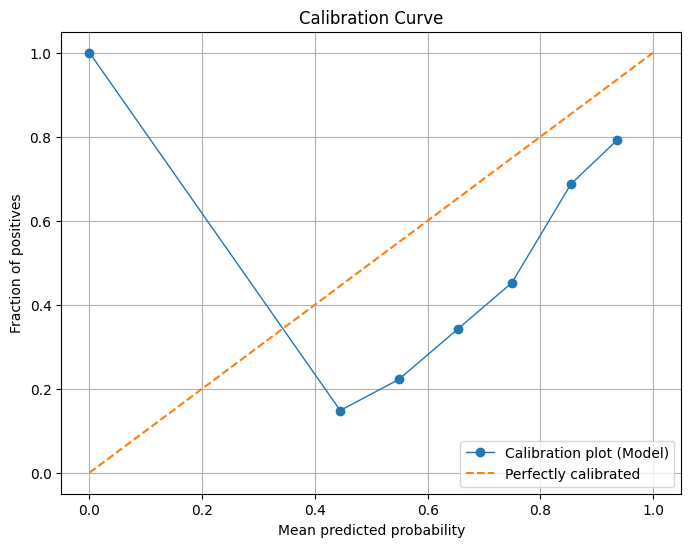

In [403]:
from sklearn.calibration import calibration_curve
true_probs, pred_probs = calibration_curve(y_true, scores, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(pred_probs, true_probs, marker='o', linewidth=1, label='Calibration plot (Model)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

In [395]:
import torch
import torch.nn.functional as F

# Assuming y_true and scores are already defined and are torch Tensors
y_true_tensor = torch.tensor(y_true).float()
scores_tensor = torch.tensor(scores).float()

# Calculate log-loss using binary cross-entropy
log_loss_value = F.binary_cross_entropy(scores_tensor, y_true_tensor)

print(f"Log-Loss: {log_loss_value.item()}")

Log-Loss: 51.13090515136719


In [92]:
import numpy as np

# Initialize counters
true_positives = []
false_positives = []
false_negatives = []

ev = []

# Iterate through all evaluation images
for eval_img in cocoEval.evalImgs:
    if eval_img is None or eval_img['aRng'] != [0, 1e10]:# or eval_img['image_id'] != 3:
        continue  # Skip if there's no evaluation data for the image

    ev.append(eval_img)

    # Extracting TP, FP, and FN from the 'evalImg' data structure
    tp = np.sum(eval_img['dtMatches'] > 0, axis=1)  # Sum across each IoU threshold
    fp = np.sum(eval_img['dtMatches'] == 0, axis=1)  # Count unmatched detections
    fn = np.sum(eval_img['gtMatches'] == 0, axis=1)  # Count unmatched ground truths

    true_positives.append(tp)
    false_positives.append(fp)
    false_negatives.append(fn)

# Example to calculate total TP, FP, FN for a specific IoU threshold (e.g., index 0)
total_tp = np.sum([tp[0] for tp in true_positives])
total_fp = np.sum([fp[0] for fp in false_positives])
total_fn = np.sum([fn[0] for fn in false_negatives])

print(f"Total True Positives (TP): {total_tp}")
print(f"Total False Positives (FP): {total_fp}")
print(f"Total False Negatives (FN): {total_fn}")


Total True Positives (TP): 141
Total False Positives (FP): 242
Total False Negatives (FN): 395


In [89]:
true_positives = np.sum(true_positives, axis=0)
false_positives = np.sum(false_positives, axis=0)
false_negatives = np.sum(false_negatives, axis=0)

# Precision, Recall, F1, AP, IoU
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision.mean():.3f}")
print(f"Recall: {recall.mean():.3f}")
print(f"F1: {f1.mean():.3f}")

Precision: 0.301
Recall: 0.215
F1: 0.251


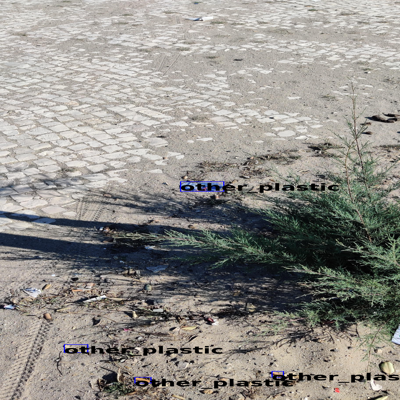

In [190]:
from PIL import Image, ImageDraw, ImageFont
font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 100)

def show_gt_image(img_id, cocoGt: COCO):
    ann_ids = cocoGt.getAnnIds(img_id)
    anns = cocoGt.loadAnns(ann_ids)
    img = cocoGt.loadImgs(img_id)[0]
    im = Image.open(img["file_name"])
    for ann in anns:
        bbox = ann["bbox"]
        x, y, w, h = bbox
        draw = ImageDraw.Draw(im)
        draw.rectangle([x, y, x+w, y+h], outline="red", width=5)
        # class name
        cat_id = ann["category_id"]
        class_name = cocoGt.cats[cat_id]["name"]
        draw.text((x, y), class_name, fill="black", font=font)
    return im

def show_pred_image(img_id, cocoDt: COCO):
    ann_ids = cocoDt.getAnnIds(img_id)
    anns = cocoDt.loadAnns(ann_ids)
    img = cocoDt.loadImgs(img_id)[0]
    im = Image.open(img["file_name"])
    for ann in anns:
        bbox = ann["bbox"]
        x, y, w, h = bbox
        draw = ImageDraw.Draw(im)
        draw.rectangle([x, y, x+w, y+h], outline="blue", width=5)
        # class name
        cat_id = ann["category_id"]
        class_name = cocoDt.cats[cat_id]["name"]
        draw.text((x, y), class_name, fill="black", font=font)
    return im

img_id = 3
show_pred_image(img_id, cocoDt).resize((400, 400))

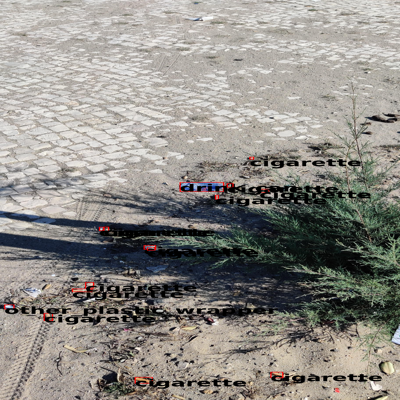

In [191]:
show_gt_image(img_id, cocoGt).resize((400, 400))

In [186]:
len(cocoGt.loadAnns(cocoGt.getAnnIds(3)))

15

In [136]:
cocoDt.cats

{1: {'id': 1, 'name': 'cigarette'},
 2: {'id': 2, 'name': 'clear_plastic_bottle'},
 3: {'id': 3, 'name': 'disposable_plastic_cup'},
 4: {'id': 4, 'name': 'drink_can'},
 5: {'id': 5, 'name': 'glass_bottle'},
 6: {'id': 6, 'name': 'other_plastic'},
 7: {'id': 7, 'name': 'other_plastic_wrapper'},
 8: {'id': 8, 'name': 'plastic_bottle_cap'},
 9: {'id': 9, 'name': 'plastic_film'},
 10: {'id': 10, 'name': 'plastic_straw'}}